# Stroke Decomposition

drive notes: https://docs.google.com/document/d/1XO1u8E0DPgl9g6yaCIBgIzvH90cOMfWVx5ndorhusfU/edit?usp=sharing






## Preprocessing
* Notes
    * for now it seems that the other morphological processes do not greatly enhance the image, before skeletonization
    * should try a light blur to try and remove 1x1 holes

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

import cv2
from skimage.morphology import skeletonize, remove_small_holes
import networkx as nx

#module for converting skeleton networks into a graph representation
import sknw

#set dpi
mpl.rcParams['figure.dpi'] = 300
mpl.rcParams['text.color'] = 'yellow'
mpl.rcParams['font.size'] = 5

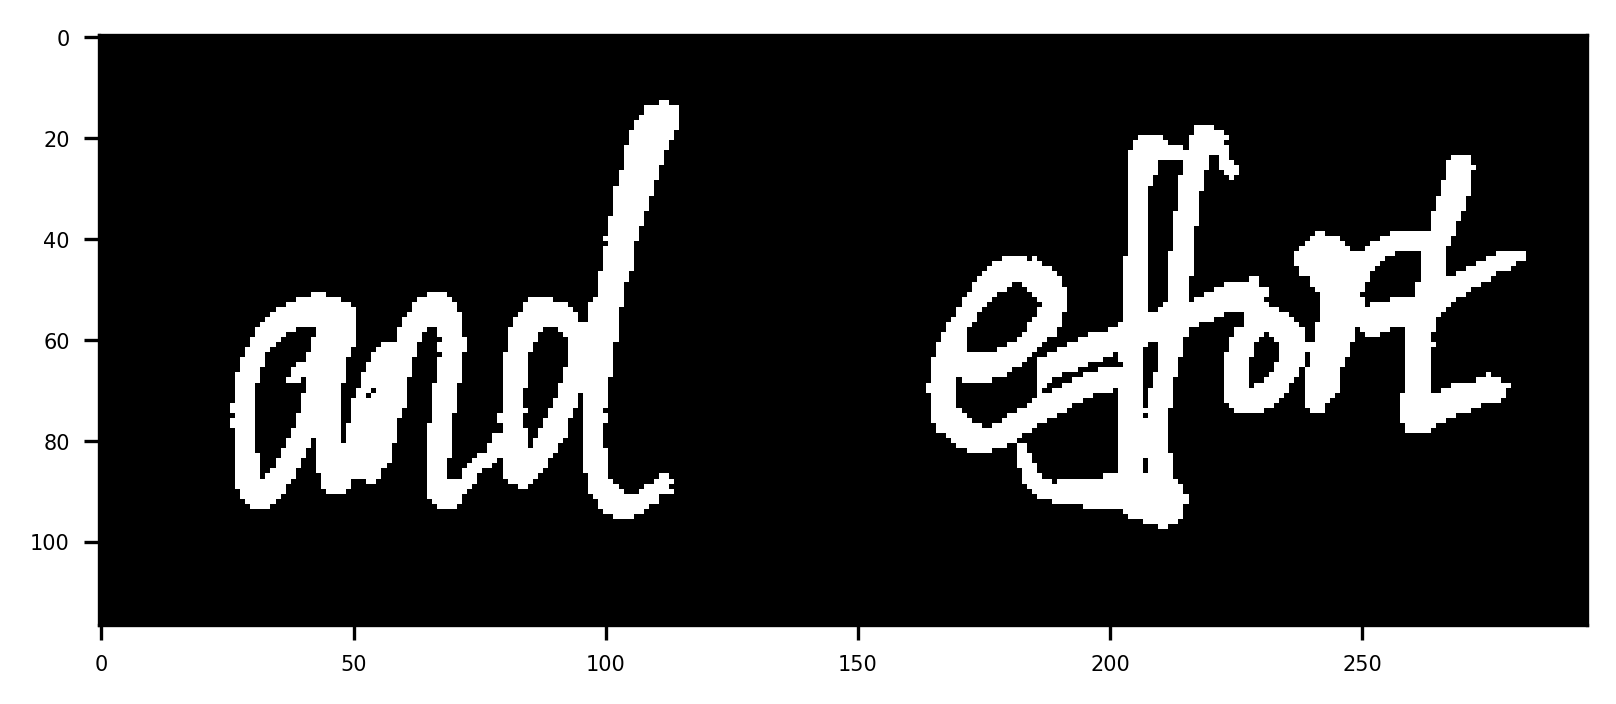

In [21]:
eng_test = cv2.imread(r'CERUG_EN_Test.png', cv2.IMREAD_GRAYSCALE)
eng_test = cv2.threshold(eng_test, 0, 1, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1] #threshold and invert image at the same time

#NOTE: imshow reduces the resolution
plt.imshow(eng_test, cmap='gray')

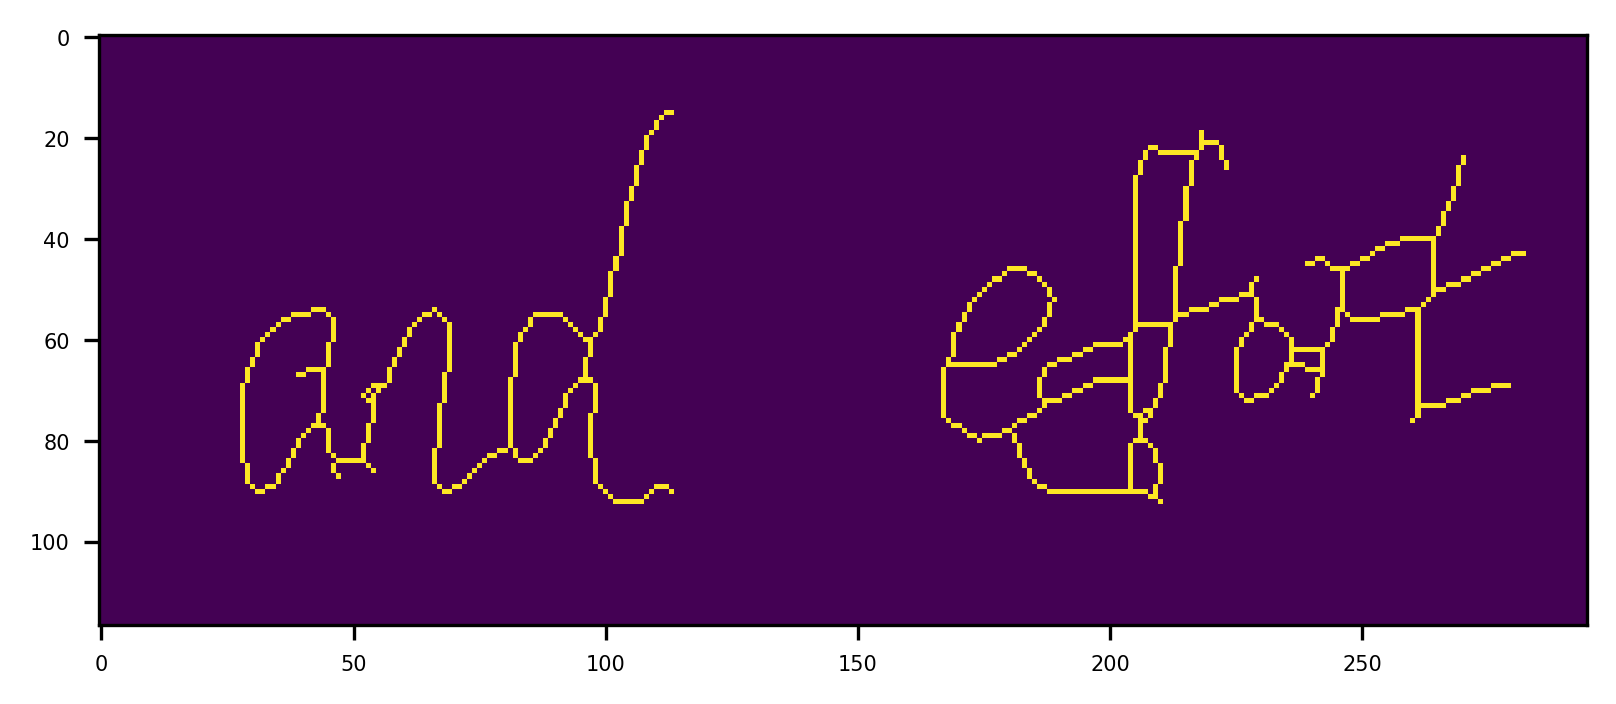

In [3]:
#test iamge one, here the image is skeletonized as is
eng_test_skele = skeletonize(eng_test)

plt.imshow(eng_test_skele)

C:\Users\JUDE\AppData\Local\Temp\ipykernel_5468\3557024178.py:2: UserWarning: Any labeled images will be returned as a boolean array. Did you mean to use a boolean array?
  eng_test_shr = remove_small_holes(eng_test, 4)


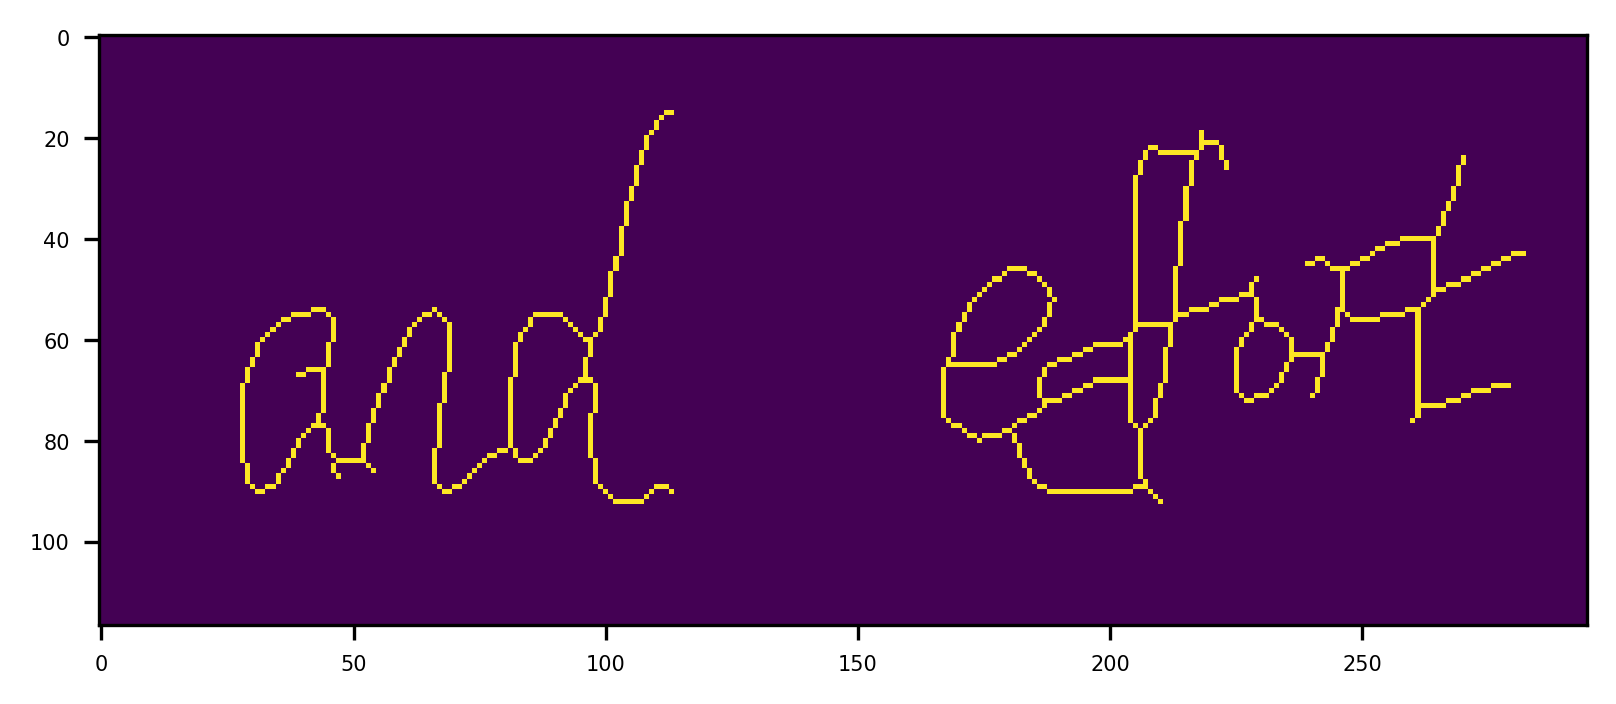

In [4]:
#test image two, small holes (around 1-2px) are considered artefacts here
eng_test_shr = remove_small_holes(eng_test, 4)
eng_test_shr_skele = skeletonize(eng_test_shr)

plt.imshow(eng_test_shr_skele)

## Graph Conversion

### sknw
source: https://github.com/Image-Py/sknw

notes:
* experimentation with yxdragons skeleton network library

In [5]:
#plot image graph of skeletonized text. also made to return graph for futher testing (later)
def plot_image_graph(image):
    #build graph from skeleton
    graph = sknw.build_sknw(image, multi=True, full=True, ring=True)

    #draw image
    plt.imshow(image, cmap='gray')

    #draw edges by pts
    #edges returns a "multi-edge view". using edges() returns a regular edge view, which doesn't contain identifiers multiple edges
    for (s, e_dict, idx) in graph.edges: 
        ps = graph[s][e_dict][idx]['pts']
        plt.plot(ps[:, 1], ps[:, 0], 'green')


    #draw node by o
    nodes = graph.nodes()
    ps = np.array([nodes[i]['o'] for i in nodes])
    plt.plot(ps[:,1], ps[:,0], 'r.', linewidth=1, markersize=1)

    #annotate nodes
    for node in nodes:
        plt.annotate(str(node), (ps[node, 1], ps[node, 0]))

    #title and show
    plt.title('Build Graph')
    plt.show()

    return graph

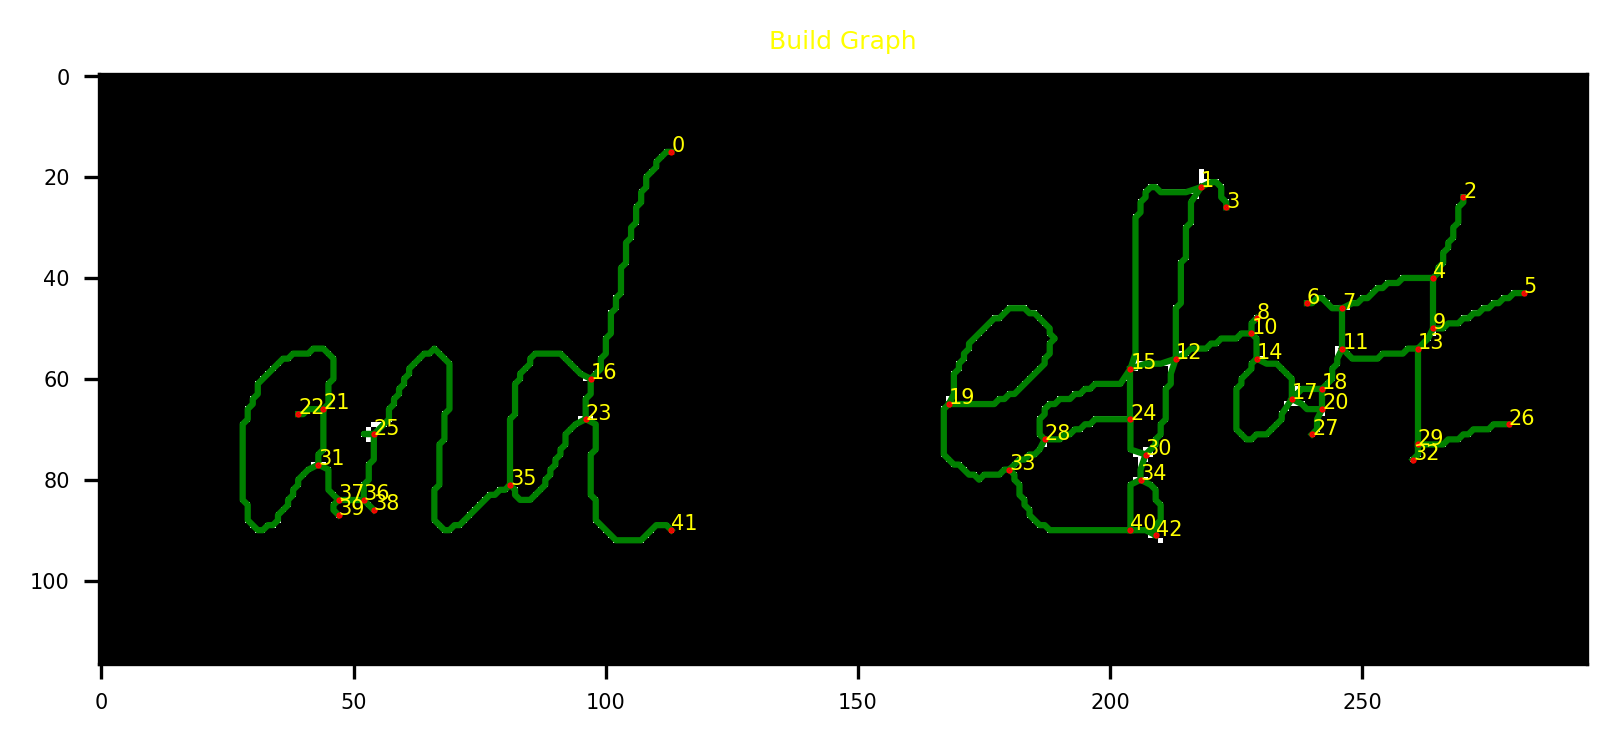

In [6]:
plot_image_graph(eng_test_skele)

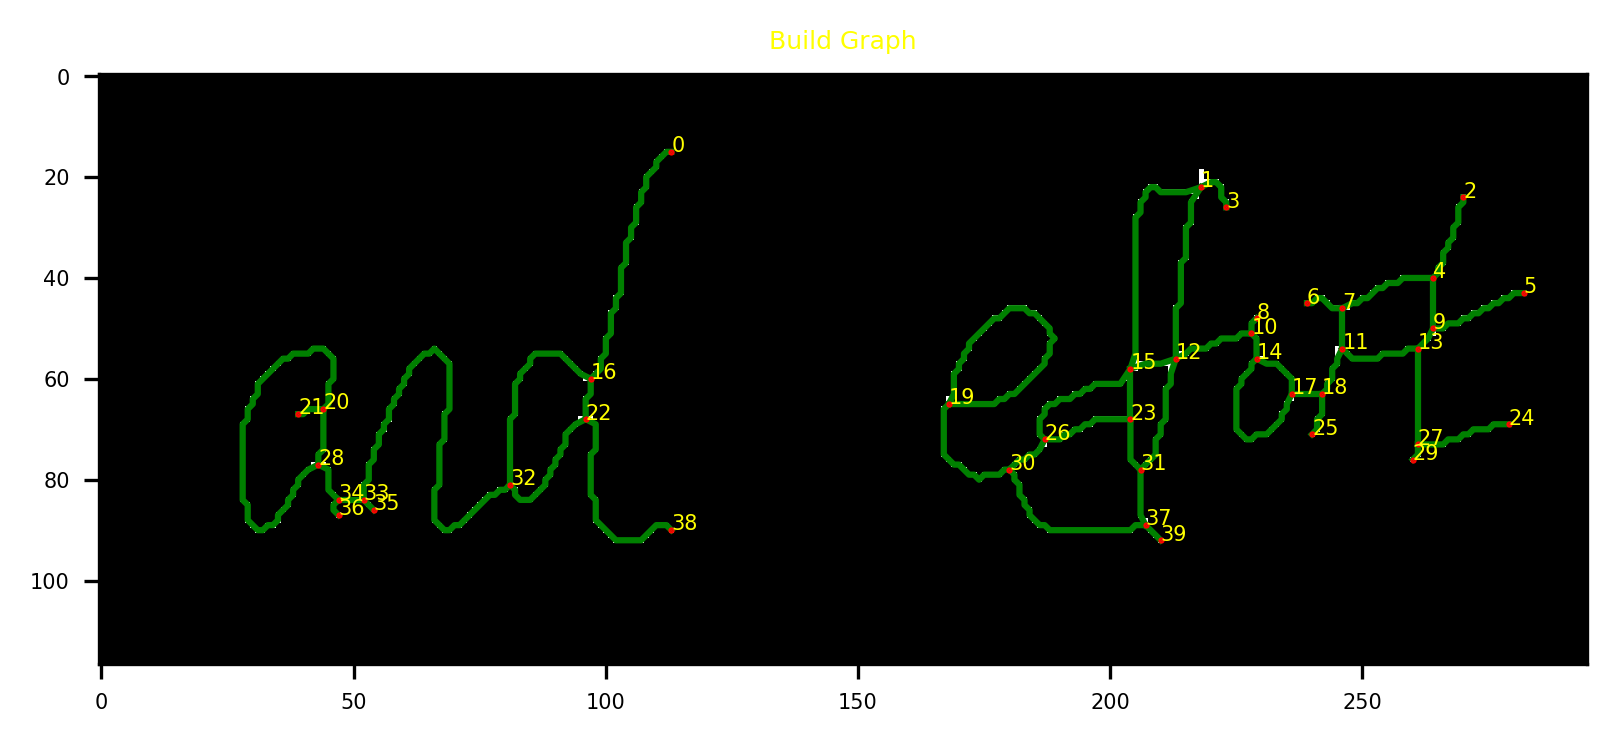

In [7]:
plot_image_graph(eng_test_shr_skele)

## Attempt 1 - Simple Graph Based Method
steps:
1. preprocess document
    * remove small holes
    * skeletonize image
3. find *critical points* and split connected components based on those branches
    * branching areas indicating stroke overlap
5. reconstruct labeled strokes to act as mask for original images
    * nn clustering used for simplicity
    * could also use morphological reconstruction if need be

In [8]:
#going to assume a preprocesed image is fed in
def segment_stroke_fragments(image):
    labels = np.zeros_like(image, dtype=int)

    #can't decide if I should pass in the graph or do it in the function like this
    graph = sknw.build_sknw(image, multi=True, full=True, ring=True)

    #TODO: figure out a way to vectorize the outer portion
    for label_idx, (node1, node2, idx) in enumerate(graph.edges):
        edge_points = graph[node1][node2][idx]['pts']

        labels[edge_points[:, 0], edge_points[:, 1]] = label_idx + 1 #need to account for zero indexing
    
    return labels



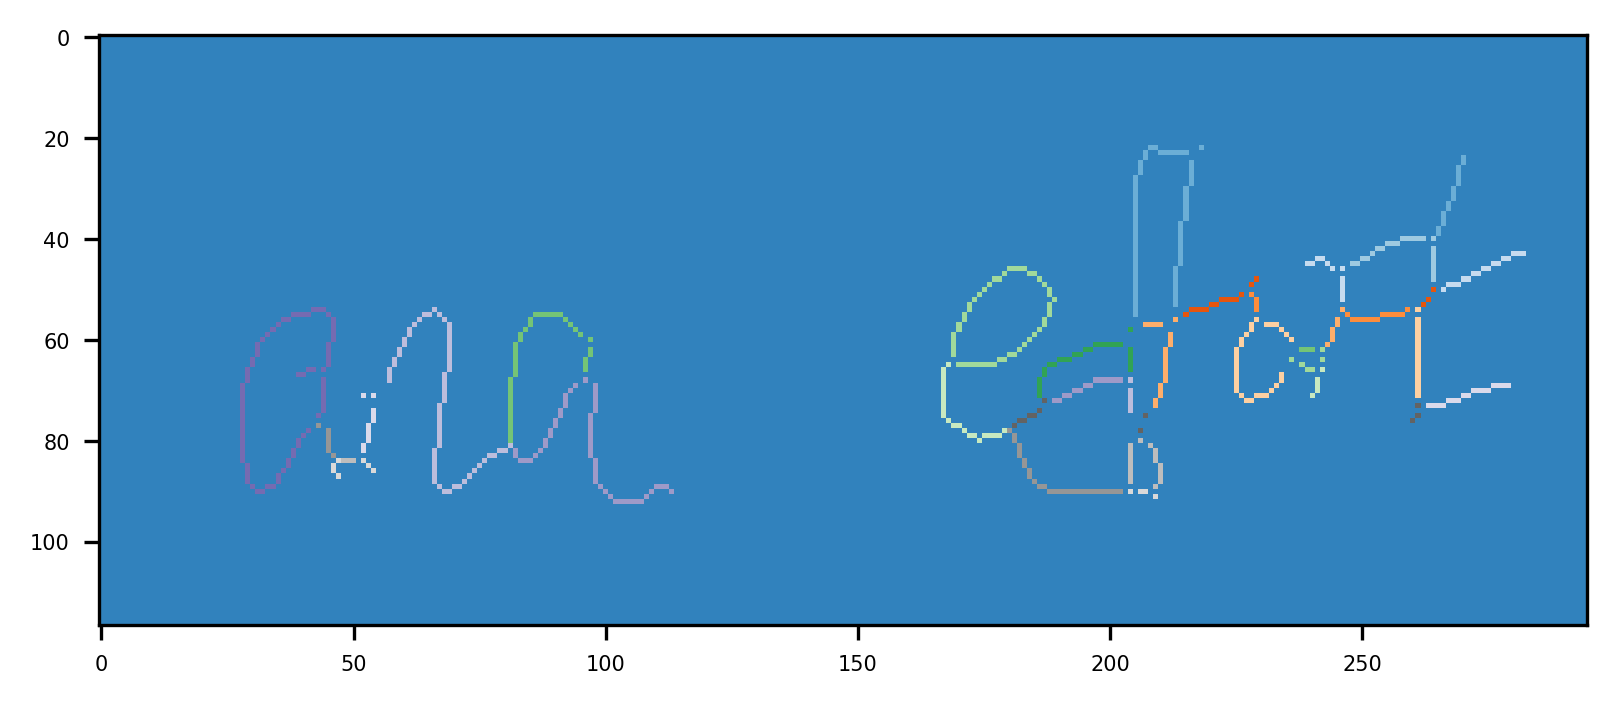

In [9]:
eng_test_skele_labeled = segment_stroke_fragments(eng_test_skele)

plt.imshow(eng_test_skele_labeled, cmap='tab20c')

* idea is to label the image based on nearest non-zero pixel label
* knearestneighbors may not be the answer to this. might be something easier

In [10]:
from sklearn.neighbors import KNeighborsClassifier

In [11]:
label_coords = np.array(eng_test_skele_labeled.nonzero()).T

In [18]:
labels = eng_test_skele_labeled[label_coords[:, 0], label_coords[:, 1]] #not sure if actually required
labels.shape

(786,)

In [13]:
cls = KNeighborsClassifier(n_neighbors=1)
cls.fit(label_coords, labels)

KNeighborsClassifier(n_neighbors=1)

In [24]:
img_coords = np.array(eng_test.nonzero()).T
eng_test[img_coords[:, 0], img_coords[:, 1]]

array([1, 1, 1, ..., 1, 1, 1], dtype=uint8)

In [15]:
img_labels = cls.predict(img_coords)
img_labels

array([ 1,  1,  1, ..., 53, 53, 53])

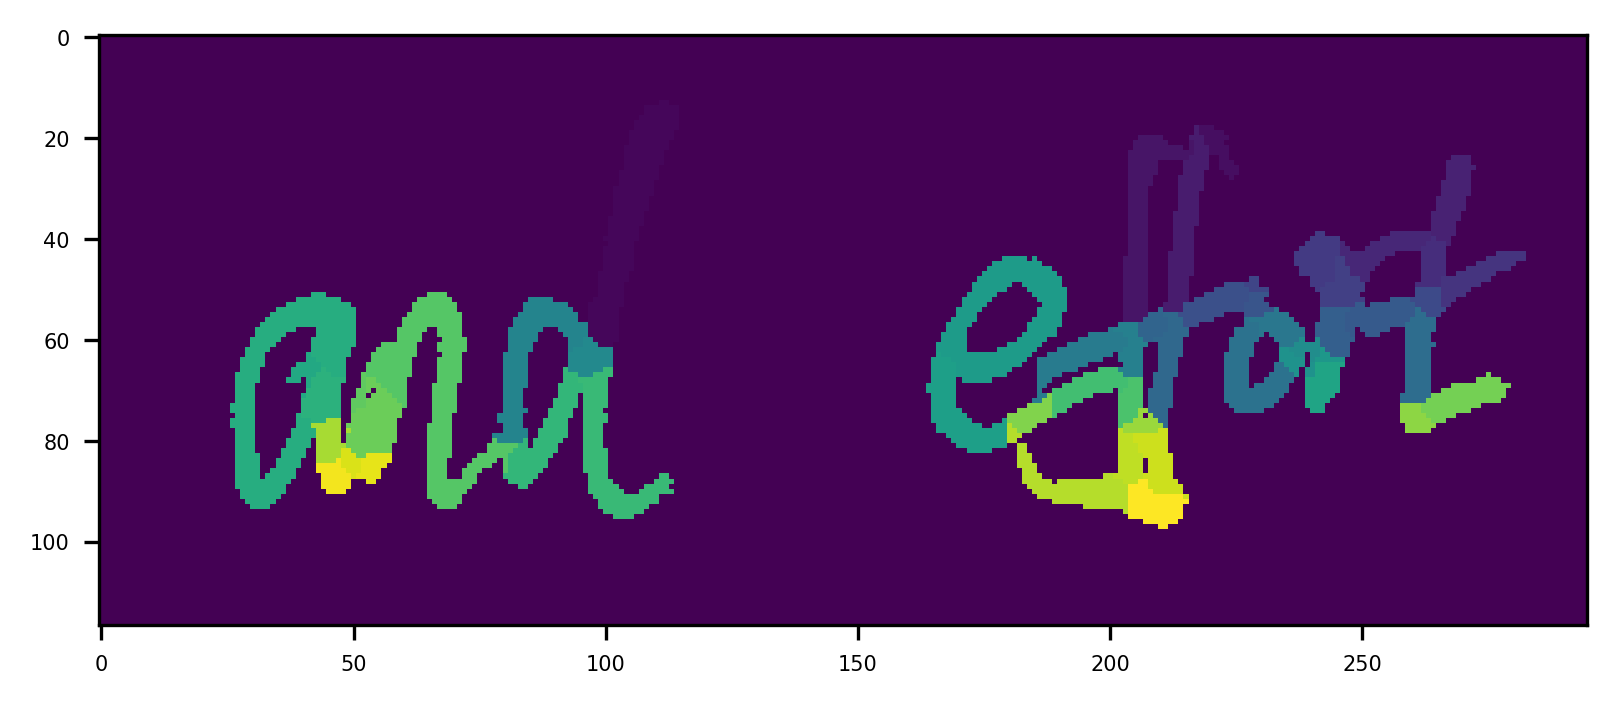

In [16]:
labeled_image = np.zeros_like(eng_test, dtype=int)
labeled_image[img_coords[:, 0], img_coords[:, 1]] = img_labels
plt.imshow(labeled_image)

Text(0.5, 0.98, 'Simple Graph Segmentation Method')

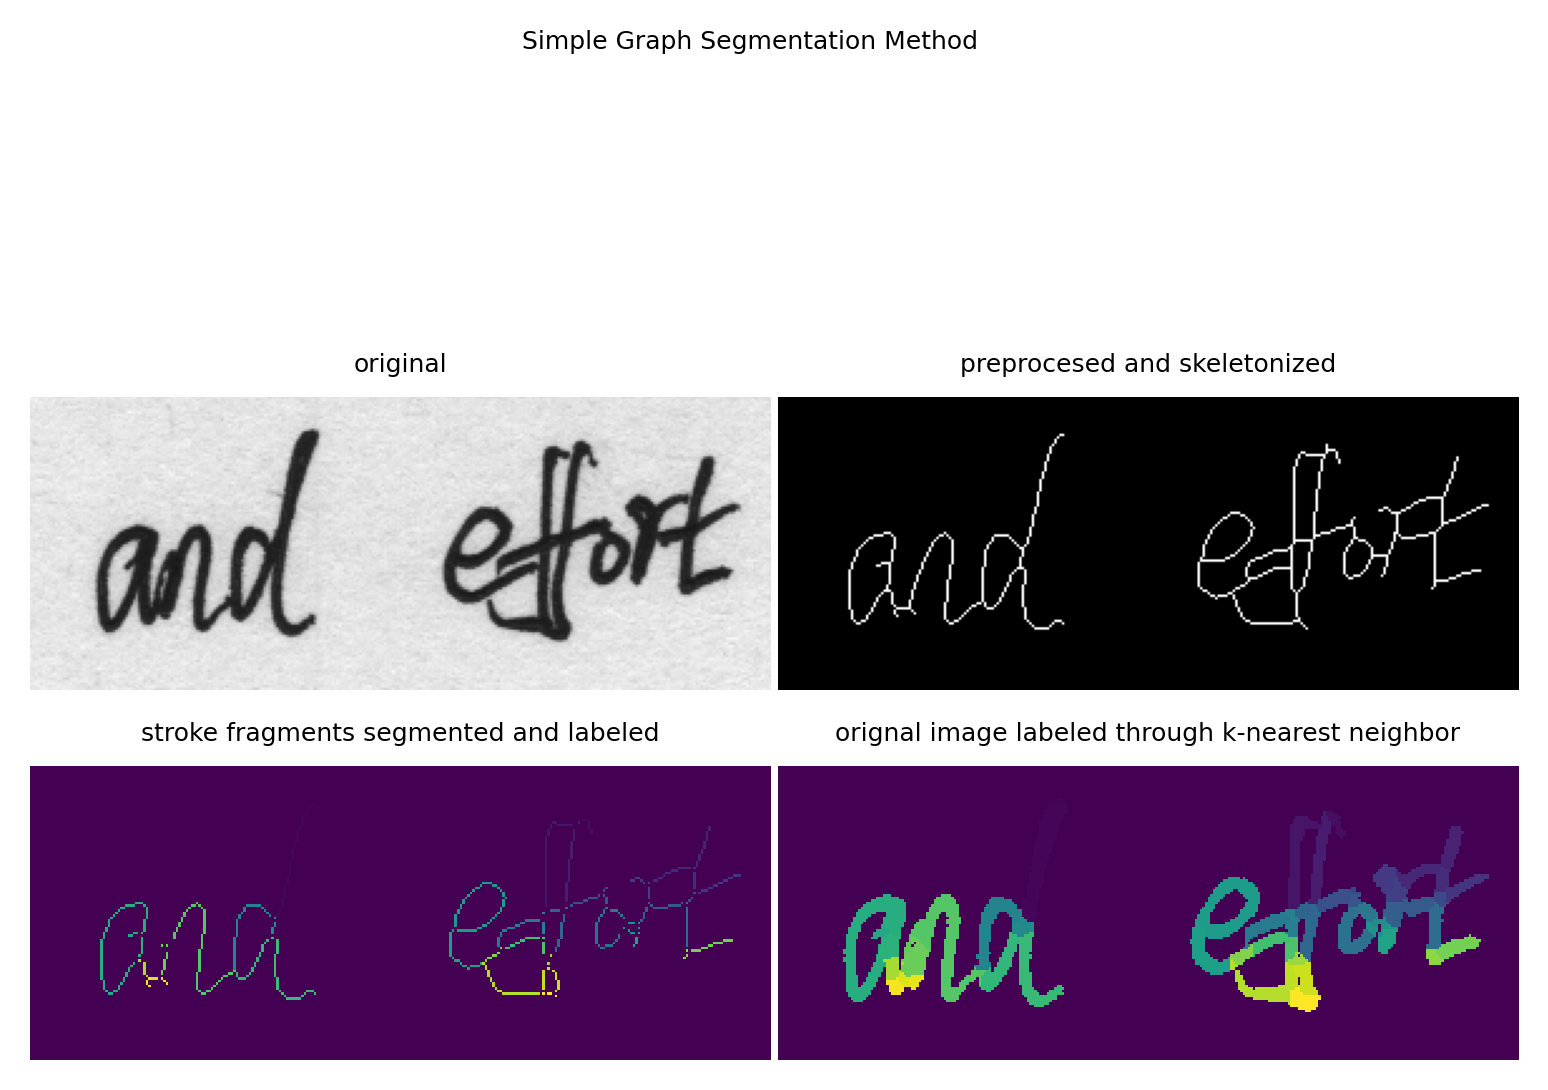

In [17]:
mpl.rcParams['text.color'] = 'black'

#figure for presentation
fig, axes = plt.subplots(2, 2)

#original image
eng_test_orig = cv2.imread("CERUG_EN_Test.png")
axes[0, 0].imshow(eng_test_orig)
axes[0, 0].set_title("original")
axes[0, 0].axis("off")

#preprocessed
axes[0, 1].imshow(eng_test_shr_skele, cmap='gray')
axes[0, 1].set_title("preprocesed and skeletonized")
axes[0, 1].axis("off")

#graph representation
axes[1, 0].imshow(eng_test_skele_labeled, interpolation="nearest")
axes[1, 0].set_title("stroke fragments segmented and labeled")
axes[1, 0].axis("off")

# region growing?
axes[1, 1].imshow(labeled_image, interpolation="nearest")
axes[1, 1].set_title("orignal image labeled through k-nearest neighbor")
axes[1, 1].axis("off")

padding = 0.01
fig.subplots_adjust(wspace=padding, hspace=-.5)
fig.suptitle("Simple Graph Segmentation Method")
